In [100]:
import pandas as pd
import numpy as np
import seaborn as sns
import os, warnings
from concurrent.futures import ThreadPoolExecutor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn.metrics import cohen_kappa_score,confusion_matrix,make_scorer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from tqdm import tqdm
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [101]:
# Suppress warnings
warnings.filterwarnings('ignore')

# Pandas option for displaying all columns
pd.options.display.max_columns = None

def process_file(filename, dirname):
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop('step', axis=1, inplace=True)
    return df.describe().values.reshape(-1), filename.split('=')[1]

def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    stats, indexes = zip(*results)
    df = pd.DataFrame(stats, columns=[f"stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    return df

# Load datasets
train = pd.read_csv('C:/MY_Masters_Project/child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('C:/MY_Masters_Project/child-mind-institute-problematic-internet-use/test.csv')
sample = pd.read_csv('C:/MY_Masters_Project/child-mind-institute-problematic-internet-use/sample_submission.csv')

# Load time series data
train_ts = load_time_series("C:/MY_Masters_Project/child-mind-institute-problematic-internet-use/series_train.parquet")
test_ts = load_time_series("C:/MY_Masters_Project/child-mind-institute-problematic-internet-use/series_test.parquet")

# Merge datasets
time_series_cols = train_ts.columns.tolist()
time_series_cols.remove('id')
train = pd.merge(train, train_ts, how="left", on='id')
test = pd.merge(test, test_ts, how="left", on='id')
train = train.drop('id', axis=1)
test = test.drop('id', axis=1)

100%|██████████| 2/2 [00:00<00:00, 15.19it/s]


In [102]:
train.head()

,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,PCIAT-Season,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii,stat_0,stat_1,stat_2,stat_3,stat_4,stat_5,stat_6,stat_7,stat_8,stat_9,stat_10,stat_11,stat_12,stat_13,stat_14,stat_15,stat_16,stat_17,stat_18,stat_19,stat_20,stat_21,stat_22,stat_23,stat_24,stat_25,stat_26,stat_27,stat_28,stat_29,stat_30,stat_31,stat_32,stat_33,stat_34,stat_35,stat_36,stat_37,stat_38,stat_39,stat_40,stat_41,stat_42,stat_43,stat_44,stat_45,stat_46,stat_47,stat_48,stat_49,stat_50,stat_51,stat_52,stat_53,stat_54,stat_55,stat_56,stat_57,stat_58,stat_59,stat_60,stat_61,stat_62,stat_63,stat_64,stat_65,stat_66,stat_67,stat_68,stat_69,stat_70,stat_71,stat_72,stat_73,stat_74,stat_75,stat_76,stat_77,stat_78,stat_79,stat_80,stat_81,stat_82,stat_83,stat_84,stat_85,stat_86,stat_87,stat_88,stat_89,stat_90,stat_91,stat_92,stat_93,stat_94,stat_95
0,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,Fall,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.06143,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,NaN,NaN,NaN,NaN,Fall,5.0,4.0,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,4.0,4.0,4.0,4.0,4.0,4.0,2.0,4.0,55.0,NaN,NaN,NaN,Fall,3.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,22.0,75.0,70.0,122.0,NaN,NaN,NaN,NaN,Fall,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,Winter,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,NaN,NaN,Fall,2.340,Fall,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Fall,46.0,64.0,Summer,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,NaN,65.0,94.0,117.0,Fall,5.0,7.0,33.0,Fall,20.0,1.0,10.2,1.0,14.7,2.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,2.170,Fall,5.0,2.0,2.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,2.0,2.0,1.0,1.0,28.0,Fall,38.0,54.0,Summer,2.0,0.0,NaN,NaN,NaN,NaN,NaN,

In [103]:
test.head()

,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,stat_0,stat_1,stat_2,stat_3,stat_4,stat_5,stat_6,stat_7,stat_8,stat_9,stat_10,stat_11,stat_12,stat_13,stat_14,stat_15,stat_16,stat_17,stat_18,stat_19,stat_20,stat_21,stat_22,stat_23,stat_24,stat_25,stat_26,stat_27,stat_28,stat_29,stat_30,stat_31,stat_32,stat_33,stat_34,stat_35,stat_36,stat_37,stat_38,stat_39,stat_40,stat_41,stat_42,stat_43,stat_44,stat_45,stat_46,stat_47,stat_48,stat_49,stat_50,stat_51,stat_52,stat_53,stat_54,stat_55,stat_56,stat_57,stat_58,stat_59,stat_60,stat_61,stat_62,stat_63,stat_64,stat_65,stat_66,stat_67,stat_68,stat_69,stat_70,stat_71,stat_72,stat_73,stat_74,stat_75,stat_76,stat_77,stat_78,stat_79,stat_80,stat_81,stat_82,stat_83,stat_84,stat_85,stat_86,stat_87,stat_88,stat_89,stat_90,stat_91,stat_92,stat_93,stat_94,stat_95
0,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,Fall,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.06143,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,22.0,75.0,70.0,122.0,NaN,NaN,NaN,NaN,Fall,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,Winter,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,NaN,NaN,Fall,2.340,Fall,46.0,64.0,Summer,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,NaN,65.0,94.0,117.0,Fall,5.0,7.0,33.0,Fall,20.0,1.0,10.2,1.0,14.7,2.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,2.170,Fall,38.0,54.0,Summer,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,NaN,60.0,97.0,117.0,Summer,6.0,9.0,37.0,Summer,18.0,1.0,NaN,NaN,NaN,NaN,5.0,0.0,7.0,0.0,7.0,0.0,7.0,1.0,Summer,3.0,3.84191,18.2943,1131.430,1923.44,15.59250,62.7757,14.0740,4.22033,18.82430,2.0,30.4041,

In [104]:
train.shape,test.shape

((3960, 177), (20, 154))

In [105]:
train_ts.shape,test_ts.shape


((996, 97), (2, 97))

In [106]:
missing_cols=set(train)-set(test)
missing_cols.remove('sii')
missing_cols

{'PCIAT-PCIAT_01',
 'PCIAT-PCIAT_02',
 'PCIAT-PCIAT_03',
 'PCIAT-PCIAT_04',
 'PCIAT-PCIAT_05',
 'PCIAT-PCIAT_06',
 'PCIAT-PCIAT_07',
 'PCIAT-PCIAT_08',
 'PCIAT-PCIAT_09',
 'PCIAT-PCIAT_10',
 'PCIAT-PCIAT_11',
 'PCIAT-PCIAT_12',
 'PCIAT-PCIAT_13',
 'PCIAT-PCIAT_14',
 'PCIAT-PCIAT_15',
 'PCIAT-PCIAT_16',
 'PCIAT-PCIAT_17',
 'PCIAT-PCIAT_18',
 'PCIAT-PCIAT_19',
 'PCIAT-PCIAT_20',
 'PCIAT-PCIAT_Total',
 'PCIAT-Season'}

In [107]:
train.isna().sum()

Basic_Demos-Enroll_Season                    0
Basic_Demos-Age                              0
Basic_Demos-Sex                              0
CGAS-Season                               1405
CGAS-CGAS_Score                           1539
Physical-Season                            650
Physical-BMI                               938
Physical-Height                            933
Physical-Weight                            884
Physical-Waist_Circumference              3062
Physical-Diastolic_BP                     1006
Physical-HeartRate                         993
Physical-Systolic_BP                      1006
Fitness_Endurance-Season                  2652
Fitness_Endurance-Max_Stage               3217
Fitness_Endurance-Time_Mins               3220
Fitness_Endurance-Time_Sec                3220
FGC-Season                                 614
FGC-FGC_CU                                1638
FGC-FGC_CU_Zone                           1678
FGC-FGC_GSND                              2886
FGC-FGC_GSND_

### Feature Engineering

#####  Dropping features

In [108]:
# dropping features with equal to or more than 50% of missing values
def dropMissingValueFeatures(train,test):
    missing_train = train.isna().mean() * 100
    cols_to_drop = missing_train[missing_train >= 50].index.tolist()
    cols_to_drop+=[i for i in train.columns if 'BIA' in i]

    train=train.drop(columns=[col for col in cols_to_drop if col in train.columns], axis=1)
    test=test.drop(columns=[col for col in cols_to_drop if col in test.columns], axis=1)
    return train,test

In [109]:
train,test=dropMissingValueFeatures(train,test)

In [110]:
missing_train = train.isna().mean() * 100
missing_test = test.isna().mean() * 100

print("Columns with missing values in df_train:")
print(missing_train[missing_train >0])

print("\nColumns with missing values in df_test:")
print(missing_test[missing_test >0])

Columns with missing values in df_train:
CGAS-Season                               35.479798
CGAS-CGAS_Score                           38.863636
Physical-Season                           16.414141
Physical-BMI                              23.686869
Physical-Height                           23.560606
Physical-Weight                           22.323232
Physical-Diastolic_BP                     25.404040
Physical-HeartRate                        25.075758
Physical-Systolic_BP                      25.404040
FGC-Season                                15.505051
FGC-FGC_CU                                41.363636
FGC-FGC_CU_Zone                           42.373737
FGC-FGC_PU                                41.666667
FGC-FGC_PU_Zone                           42.651515
FGC-FGC_SRL                               41.792929
FGC-FGC_SRL_Zone                          42.752525
FGC-FGC_SRR                               41.742424
FGC-FGC_SRR_Zone                          42.702020
FGC-FGC_TL             

In [111]:
train.shape[1]-test.shape[1]

23

In [112]:
wa = pd.DataFrame(data=train, columns=['PCIAT-PCIAT_Total', 'sii'])
wa[pd.notna(wa['PCIAT-PCIAT_Total'])]

,PCIAT-PCIAT_Total,sii
0,55.0,2.0
1,0.0,0.0
2,28.0,0.0
3,44.0,1.0
5,34.0,1.0
...,...,...
3953,22.0,0.0
3954,33.0,1.0
3955,32.0,1.0
3957,31.0,1.0


In [113]:
train_pciatAvg=train.copy()
test_pciatAvg=test.copy()
pciat_columns = [f'PCIAT-PCIAT_{i:02d}' for i in range(1, 21)]
train_pciatAvg['Pciat_total_min']=train_pciatAvg[pciat_columns].fillna(0).sum(axis=1)
train_pciatAvg['Pciat_total_max']=train_pciatAvg[pciat_columns].fillna(5).sum(axis=1)
train_pciatAvg['Pciat_total_avg']=(train_pciatAvg['Pciat_total_max']+train_pciatAvg['Pciat_total_min'])/2
train_pciatAvg.drop(columns=['Pciat_total_max','Pciat_total_min','PCIAT-PCIAT_Total', 'PCIAT-Season','sii'] + pciat_columns, inplace=True)

def calSii(total):
    if total<=30:
        return 0  # None
    elif 31 <= total <= 49:
        return 1  # Mild
    elif 50 <= total <= 79:
        return 2  # Moderate
    else:
        return 3  # Severe

train_pciatAvg['sii_pred']=train_pciatAvg['Pciat_total_avg'].apply(calSii)
train_pciatAvg.drop('Pciat_total_avg',axis=1)

,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii_pred
0,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,NaN,NaN,NaN,Fall,0.0,0.0,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,NaN,NaN,NaN,Fall,3.0,2
1,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,75.0,70.0,122.0,Fall,3.0,0.0,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,Fall,46.0,64.0,Summer,0.0,0
2,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,65.0,94.0,117.0,Fall,20.0,1.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,Fall,38.0,54.0,Summer,2.0,0
3,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,60.0,97.0,117.0,Summer,18.0,1.0,5.0,0.0,7.0,0.0,7.0,0.0,7.0,1.0,Summer,31.0,45.0,Winter,0.0,1
4,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3955,Fall,13,0,Spring,60.0,Fall,16.362460,59.5,82.4,71.0,70.0,104.0,Fall,16.0,0.0,10.0,1.0,8.0,1.0,9.0,1.0,12.0,1.0,Winter,35.0,50.0,Fall,1.0,1
3956,Winter,10,0,NaN,NaN,Spring,18.764678,53.5,76.4,60.0,78.0,118.0,Spring,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,12.0,1.0,NaN,NaN,NaN,Winter,0.0,2
3957,Fall,11,0,Spring,68.0,Winter,21.441500,60.0,109.8,79.0,99.0,116.0,Winter,15.0,1.0,0.0,0.0,10.0,1.0,10.0,1.0,14.0,1.0,Winter,56.0,77.0,Fall,0.0,1
3958,Spring,13,0,Spring,70.0,Winter,12.235895,70.7,87.0,59.0,61.0,113.0,Spring,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Spring,33.0,47.0,Spring,1.0,0


In [114]:
missing_train = train_pciatAvg.isna().mean() * 100
missing_test = test.isna().mean() * 100

print("Columns with missing values in df_train:")
print(missing_train[missing_train >0])

print("\nColumns with missing values in df_test:")
print(missing_test[missing_test >0])

Columns with missing values in df_train:
CGAS-Season                               35.479798
CGAS-CGAS_Score                           38.863636
Physical-Season                           16.414141
Physical-BMI                              23.686869
Physical-Height                           23.560606
Physical-Weight                           22.323232
Physical-Diastolic_BP                     25.404040
Physical-HeartRate                        25.075758
Physical-Systolic_BP                      25.404040
FGC-Season                                15.505051
FGC-FGC_CU                                41.363636
FGC-FGC_CU_Zone                           42.373737
FGC-FGC_PU                                41.666667
FGC-FGC_PU_Zone                           42.651515
FGC-FGC_SRL                               41.792929
FGC-FGC_SRL_Zone                          42.752525
FGC-FGC_SRR                               41.742424
FGC-FGC_SRR_Zone                          42.702020
FGC-FGC_TL             

In [115]:
train_pciatAvg.shape,test.shape

((3960, 30), (20, 28))

In [116]:
train_pciatAvg.sample(10)

,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,Pciat_total_avg,sii_pred
3379,Fall,16,1,NaN,NaN,Fall,26.186521,63.5,150.2,72.0,79.0,123.0,Fall,0.0,0.0,0.0,0.0,12.0,1.0,12.0,1.0,11.0,1.0,NaN,NaN,NaN,Fall,0.0,50.0,2
910,Winter,10,1,Fall,91.0,Summer,16.360727,55.0,70.4,83.0,81.0,120.0,Summer,8.0,0.0,10.0,1.0,8.0,0.0,5.0,0.0,7.5,0.0,Summer,31.0,45.0,Summer,0.0,9.0,0
3787,Fall,5,0,Winter,60.0,Fall,17.502376,44.0,48.2,82.0,88.0,128.0,Fall,0.0,0.0,1.0,0.0,16.0,1.0,15.0,1.0,11.0,1.0,NaN,NaN,NaN,Fall,0.0,1.0,0
3560,Fall,8,1,Summer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,2
273,Summer,7,0,Fall,58.0,Fall,25.276967,53.0,101.0,103.0,103.0,145.0,Fall,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,38.0,54.0,Summer,2.0,23.0,0
2140,Spring,9,0,Summer,67.0,Fall,17.454458,54.0,72.4,61.0,86.0,111.0,Spring,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Spring,30.0,43.0,Spring,1.0,55.0,2
825,Summer,9,1,NaN,NaN,Summer,15.574005,54.0,64.6,58.0,79.0,109.0,Summer,0.0,0.0,1.0,0.0,21.0,1.0,21.0,1.0,8.0,1.0,Summer,29.0,42.0,Summer,0.0,2.0,0
2796,Fall,7,0,Winter,50.0,Fall,16.691050,52.0,64.2,72.0,76.0,102.0,Fall,10.0,1.0,8.0,1.0,9.0,1.0,10.0,1.0,8.0,1.0,Fall,57.0,79.0,Fall,0.0,14.0,0
3361,Spring,13,1,NaN,NaN,Spring,NaN,NaN,NaN,NaN,NaN,NaN,Spring,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Spring,1.0,50.0,2
1323,Fall,12,0,Spring,80.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Winter,37.0,1.0,19.0,1.0,7.0,0.0,7.0,0.0,15.0,1.0,Winter,57.0,79.0,Fall,2.0,41.0,1


In [117]:
test.sample(5)

,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday
4,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Winter,9,0,Fall,71.0,Summer,18.292347,56.00,81.6,60.0,97.0,117.0,Summer,18.0,1.0,5.0,0.0,7.0,0.0,7.0,0.0,7.0,1.0,Summer,31.0,45.0,Winter,0.0
18,Winter,6,0,Spring,60.0,Winter,30.094649,37.50,60.2,61.0,91.0,95.0,Winter,6.0,1.0,0.0,0.0,4.0,0.0,4.0,0.0,7.0,1.0,Winter,39.0,55.0,Winter,3.0
12,Fall,13,0,NaN,NaN,Winter,21.079065,57.75,100.0,63.0,79.0,150.0,Winter,24.0,1.0,20.0,1.0,8.0,1.0,9.5,1.0,12.5,1.0,Fall,33.0,47.0,Fall,1.0
16,Spring,5,1,Summer,80.0,Spring,17.284504,44.00,47.6,61.0,76.0,109.0,Spring,0.0,0.0,0.0,0.0,10.5,1.0,10.0,1.0,7.0,1.0,Spring,37.0,53.0,Spring,0.0


##### - Encoding Age_Group and Basic_Demos-Sex

PreInt_EduHx-computerinternet_hoursday    1.000000
Basic_Demos-Age                           0.441822
SDS-SDS_Total_T                           0.086050
SDS-SDS_Total_Raw                         0.083501
Age_Group_Adults                          0.146514
Age_Group_Children                       -0.389975
Basic_Demos-Sex_1                        -0.000579
Name: PreInt_EduHx-computerinternet_hoursday, dtype: float64


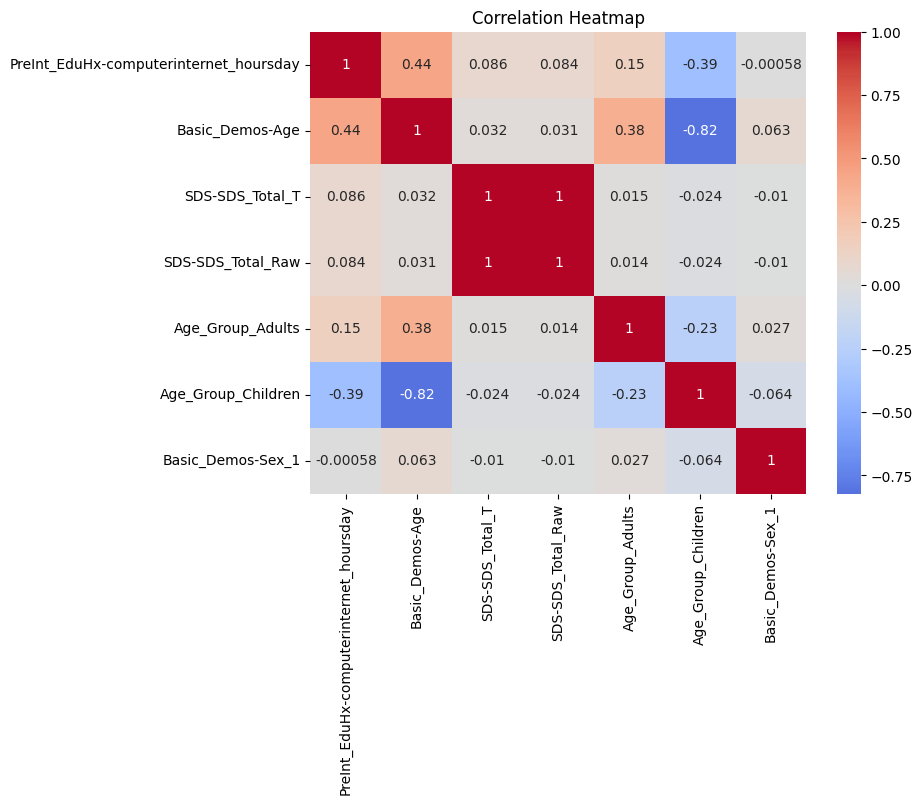

In [118]:
from sklearn.preprocessing import OneHotEncoder

# Exclude rows where 'PreInt_EduHx-computerinternet_hoursday' is NaN and select relevant columns
filtered_data = train_pciatAvg[train_pciatAvg['PreInt_EduHx-computerinternet_hoursday'].notna()][['PreInt_EduHx-computerinternet_hoursday','Basic_Demos-Age', 'Basic_Demos-Sex','SDS-SDS_Total_T', 'SDS-SDS_Total_Raw']]

# Create Age_Group
filtered_data['Age_Group'] = pd.cut(filtered_data['Basic_Demos-Age'], bins=[4, 12, 18, 22], labels=['Children', 'Adolescents', 'Adults'])

# OneHotEncode both Age_Group and Basic_Demos-Sex
drop_enc = OneHotEncoder(drop='first', sparse_output=False)
categorical_cols = ['Age_Group', 'Basic_Demos-Sex']
encoded_cols = drop_enc.fit_transform(filtered_data[categorical_cols])

# Create DataFrame for the encoded columns
encoded_df = pd.DataFrame(encoded_cols, columns=drop_enc.get_feature_names_out(categorical_cols))

# Concatenate encoded columns with the original filtered_data
filtered_data = pd.concat([filtered_data.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)

# Now you can drop the original categorical columns if needed
filtered_data.drop(categorical_cols, axis=1, inplace=True)

# Calculate the correlation matrix
corr_matrix = filtered_data.corr()
print(filtered_data.corr()['PreInt_EduHx-computerinternet_hoursday'])

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

##### - Imputing features

In [119]:
def imputing(df):
    # Step 1: Fill missing values in season-related categorical columns with their most frequent value (mode)
    fill_with_mode = ['CGAS-Season', 'Physical-Season', 'FGC-Season', 'SDS-Season', 'PreInt_EduHx-Season']
    for col in fill_with_mode:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].mode()[0])

    # Step 2: Fill missing numeric values using the median of each column.
    df['CGAS-CGAS_Score'] = df['CGAS-CGAS_Score'].fillna(df['CGAS-CGAS_Score'].median())

    # Step 3: Groupby the columns age group and sex
    df['Age_Group'] = pd.cut(df['Basic_Demos-Age'], bins=[4, 12, 18, 22], labels=['Children', 'Adolescents', 'Adults'])
    group_cols = ['Age_Group', 'Basic_Demos-Sex']

    # Step 4: Handle missing values for height and weight 
    for col in ['Physical-Weight', 'Physical-Height']:
        # Step 4a: Fill using median grouped by age group and gender
        df[col] = df.groupby(group_cols)[col].transform(lambda x: x.fillna(x.median()))

        # Step 4b: Fill remaining missing values using median grouped by age group
        missing_vals_mask = df[col].isna()  
        df.loc[missing_vals_mask, col] = df.loc[missing_vals_mask].groupby('Age_Group')[col].transform(lambda x: x.fillna(x.median()))

        # Step 4c: Fill any remaining missing values using overall median
        df.loc[df[col].isna(), col] = df[col].median()  


    # Step 5: Compute BMI using available height and weight data (converted to metric units)

    
        df['Physical-Weight'] = df['Physical-Weight'] * 0.453592
        df['Physical-Height'] = df['Physical-Height'] * 0.0254

    df.loc[df['Physical-BMI'].isna(), 'Physical-BMI'] = df.apply(
        lambda row: row['Physical-Weight'] / (row['Physical-Height'] ** 2), axis=1
    )

    # Step 6: Fill missing physical features such as blood pressure and heart rate
    phys_cols = ['Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP']
    for col in phys_cols:
        # Step 6a: Impute using median within age group and gender
        df[col] = df.groupby(group_cols)[col].transform(lambda x: x.fillna(x.median()))

        # Step 6b: Fill remaining values based on age group median
        missing_vals_mask = df[col].isna()  # Create a mask for NaN values
        df.loc[missing_vals_mask, col] = df.loc[missing_vals_mask].groupby('Age_Group')[col].transform(lambda x: x.fillna(x.median()))

        # Step 6c:  Final fallback to overall column median
        df[col] = df[col].fillna(df[col].median())

   # Step 7: Fill missing fitness assessment scores using grouped medians
    fitness_cols = [i for i in train_pciatAvg.columns if 'FGC' in i and i !='FGC-Season']
    for col in fitness_cols:
        df[col] = df.groupby(group_cols)[col].transform(lambda x: x.fillna(x.median()))
        df[col] = df[col].fillna(df[col].median())

     # Step 8: Impute sleep quality scores 
    group_cols_sleep = ['Age_Group', 'Basic_Demos-Sex', 'CGAS-Season', 'Physical-Season',
                  'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP'] + fitness_cols

    for col in ['SDS-SDS_Total_Raw', 'SDS-SDS_Total_T']:
        # Only calculate for rows where the current column value is missing
        missing_vals_mask = df[col].isna() 

        # Impute based on all relevant groups including SII for missing values
        df.loc[missing_vals_mask, col] = df.loc[missing_vals_mask].groupby(group_cols_sleep)[col].transform(lambda x: x.fillna(x.median()))

        # fallback incase of some condition mismatch
        missing_vals_mask = df[col].isna()
        df.loc[missing_vals_mask, col] = df.loc[missing_vals_mask].groupby('Age_Group')[col].transform(lambda x: x.fillna(x.median()))
        df[col] = df[col].fillna(df[col].median())

    # Step 9: Impute internet usage time by grouping based on age group
    df['PreInt_EduHx-computerinternet_hoursday'] = df.apply(
        lambda row: row['PreInt_EduHx-computerinternet_hoursday'] if not pd.isna(row['PreInt_EduHx-computerinternet_hoursday']) else
        df.groupby(['Age_Group'])['PreInt_EduHx-computerinternet_hoursday'].median().get(
            (row['Age_Group']), np.nan), axis=1)

    # Step 10: Fill remaining missing internet usage values with overall median
    df['PreInt_EduHx-computerinternet_hoursday'].fillna(df['PreInt_EduHx-computerinternet_hoursday'].median(), inplace=True)

    return df

train_pciatAvg=imputing(train_pciatAvg)
test=imputing(test)

In [120]:
train_pciatAvg.isna().sum()

Basic_Demos-Enroll_Season                 0
Basic_Demos-Age                           0
Basic_Demos-Sex                           0
CGAS-Season                               0
CGAS-CGAS_Score                           0
Physical-Season                           0
Physical-BMI                              0
Physical-Height                           0
Physical-Weight                           0
Physical-Diastolic_BP                     0
Physical-HeartRate                        0
Physical-Systolic_BP                      0
FGC-Season                                0
FGC-FGC_CU                                0
FGC-FGC_CU_Zone                           0
FGC-FGC_PU                                0
FGC-FGC_PU_Zone                           0
FGC-FGC_SRL                               0
FGC-FGC_SRL_Zone                          0
FGC-FGC_SRR                               0
FGC-FGC_SRR_Zone                          0
FGC-FGC_TL                                0
FGC-FGC_TL_Zone                 

In [121]:
test.isna().sum()

Basic_Demos-Enroll_Season                 0
Basic_Demos-Age                           0
Basic_Demos-Sex                           0
CGAS-Season                               0
CGAS-CGAS_Score                           0
Physical-Season                           0
Physical-BMI                              0
Physical-Height                           0
Physical-Weight                           0
Physical-Diastolic_BP                     0
Physical-HeartRate                        0
Physical-Systolic_BP                      0
FGC-Season                                0
FGC-FGC_CU                                0
FGC-FGC_CU_Zone                           0
FGC-FGC_PU                                0
FGC-FGC_PU_Zone                           0
FGC-FGC_SRL                               0
FGC-FGC_SRL_Zone                          0
FGC-FGC_SRR                               0
FGC-FGC_SRR_Zone                          0
FGC-FGC_TL                                0
FGC-FGC_TL_Zone                 

In [122]:
train_pciatAvg=train_pciatAvg.drop(['Pciat_total_avg','Basic_Demos-Age'],axis=1)
test=test.drop('Basic_Demos-Age',axis=1)

In [123]:
train_pciatAvg.shape,test.shape

((3960, 29), (20, 28))

#################### - Missing values settled - ##########################

### Encoding categorical values

In [124]:
train_pciatAvg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3960 entries, 0 to 3959
Data columns (total 29 columns):
 #   Column                                  Non-Null Count  Dtype   
---  ------                                  --------------  -----   
 0   Basic_Demos-Enroll_Season               3960 non-null   object  
 1   Basic_Demos-Sex                         3960 non-null   int64   
 2   CGAS-Season                             3960 non-null   object  
 3   CGAS-CGAS_Score                         3960 non-null   float64 
 4   Physical-Season                         3960 non-null   object  
 5   Physical-BMI                            3960 non-null   float64 
 6   Physical-Height                         3960 non-null   float64 
 7   Physical-Weight                         3960 non-null   float64 
 8   Physical-Diastolic_BP                   3960 non-null   float64 
 9   Physical-HeartRate                      3960 non-null   float64 
 10  Physical-Systolic_BP                    3960 non

In [125]:
train_pciatAvg['Age_Group'].unique()

['Children', 'Adolescents', 'Adults']
Categories (3, object): ['Children' < 'Adolescents' < 'Adults']

**Encoding Age_Group**

In [126]:
train_pciatAvg['Age_Group']=train_pciatAvg['Age_Group'].map({'Children':0,'Adolescents':1,'Adults':2}).astype(np.int32)
test['Age_Group']=test['Age_Group'].map({'Children':0,'Adolescents':1,'Adults':2}).astype(np.int32)

In [127]:
train_pciatAvg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3960 entries, 0 to 3959
Data columns (total 29 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Basic_Demos-Enroll_Season               3960 non-null   object 
 1   Basic_Demos-Sex                         3960 non-null   int64  
 2   CGAS-Season                             3960 non-null   object 
 3   CGAS-CGAS_Score                         3960 non-null   float64
 4   Physical-Season                         3960 non-null   object 
 5   Physical-BMI                            3960 non-null   float64
 6   Physical-Height                         3960 non-null   float64
 7   Physical-Weight                         3960 non-null   float64
 8   Physical-Diastolic_BP                   3960 non-null   float64
 9   Physical-HeartRate                      3960 non-null   float64
 10  Physical-Systolic_BP                    3960 non-null   floa

In [128]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 28 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Basic_Demos-Enroll_Season               20 non-null     object 
 1   Basic_Demos-Sex                         20 non-null     int64  
 2   CGAS-Season                             20 non-null     object 
 3   CGAS-CGAS_Score                         20 non-null     float64
 4   Physical-Season                         20 non-null     object 
 5   Physical-BMI                            20 non-null     float64
 6   Physical-Height                         20 non-null     float64
 7   Physical-Weight                         20 non-null     float64
 8   Physical-Diastolic_BP                   20 non-null     float64
 9   Physical-HeartRate                      20 non-null     float64
 10  Physical-Systolic_BP                    20 non-null     float64


In [129]:
season_cols=[col for col in train_pciatAvg.columns if 'Season' in col]

**Encoding all season features**

In [130]:
season_cols

['Basic_Demos-Enroll_Season',
 'CGAS-Season',
 'Physical-Season',
 'FGC-Season',
 'SDS-Season',
 'PreInt_EduHx-Season']

In [131]:
train_pciatAvg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3960 entries, 0 to 3959
Data columns (total 29 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Basic_Demos-Enroll_Season               3960 non-null   object 
 1   Basic_Demos-Sex                         3960 non-null   int64  
 2   CGAS-Season                             3960 non-null   object 
 3   CGAS-CGAS_Score                         3960 non-null   float64
 4   Physical-Season                         3960 non-null   object 
 5   Physical-BMI                            3960 non-null   float64
 6   Physical-Height                         3960 non-null   float64
 7   Physical-Weight                         3960 non-null   float64
 8   Physical-Diastolic_BP                   3960 non-null   float64
 9   Physical-HeartRate                      3960 non-null   float64
 10  Physical-Systolic_BP                    3960 non-null   floa

In [132]:
train_pciatAvg.columns.tolist()

['Basic_Demos-Enroll_Season',
 'Basic_Demos-Sex',
 'CGAS-Season',
 'CGAS-CGAS_Score',
 'Physical-Season',
 'Physical-BMI',
 'Physical-Height',
 'Physical-Weight',
 'Physical-Diastolic_BP',
 'Physical-HeartRate',
 'Physical-Systolic_BP',
 'FGC-Season',
 'FGC-FGC_CU',
 'FGC-FGC_CU_Zone',
 'FGC-FGC_PU',
 'FGC-FGC_PU_Zone',
 'FGC-FGC_SRL',
 'FGC-FGC_SRL_Zone',
 'FGC-FGC_SRR',
 'FGC-FGC_SRR_Zone',
 'FGC-FGC_TL',
 'FGC-FGC_TL_Zone',
 'SDS-Season',
 'SDS-SDS_Total_Raw',
 'SDS-SDS_Total_T',
 'PreInt_EduHx-Season',
 'PreInt_EduHx-computerinternet_hoursday',
 'sii_pred',
 'Age_Group']

In [133]:
X=train_pciatAvg.drop('sii_pred',axis=1)
y=train_pciatAvg['sii_pred']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [134]:
# Count class distribution in the training set
print(y_train.value_counts())

# Specifically for class 3
print("Number of class 3 samples in training set:", (y_train == 3).sum())


sii_pred
0    1084
2    1050
1     495
3      24
Name: count, dtype: int64
Number of class 3 samples in training set: 24


In [135]:
transformer=ColumnTransformer(transformers=
[('trn1',OneHotEncoder(sparse_output=False,drop='first',handle_unknown='ignore'),season_cols)],remainder='passthrough')

In [136]:
X_train = transformer.fit_transform(X_train)
X_test = transformer.transform(X_test)
test = transformer.transform(test)

# Converting transformed arrays back to DataFrames
X_train = pd.DataFrame(X_train, columns=transformer.get_feature_names_out())
X_test = pd.DataFrame(X_test, columns=transformer.get_feature_names_out())
test = pd.DataFrame(test, columns=transformer.get_feature_names_out())

##### - Scaling features (can be skipped)

In [137]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
test= scaler.transform(test)

##### - Defining Evaluation metric

In [138]:
def quadratic_weighted_kappa(y_true, y_pred, n_classes=4):
    O = confusion_matrix(y_true, y_pred)
    W = np.zeros((n_classes, n_classes))

    for i in range(n_classes):
        for j in range(n_classes):
            W[i, j] = (i - j) ** 2 / (n_classes - 1) ** 2

    E = np.outer(np.sum(O, axis=1), np.sum(O, axis=0)) / np.sum(O)

    num = np.sum(W * O)
    denom = np.sum(W * E)

    kappa = 1 - (num / denom)
    return kappa

### Model Training

In [139]:
# Defining the models
models = {
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    'LightGBM': LGBMClassifier(verbose=-1),
    'CatBoost': CatBoostClassifier(silent=True)
}

results = {}
for name, model in models.items():
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=make_scorer(quadratic_weighted_kappa))
    average_qwk = np.mean(scores)
    results[name] = average_qwk

for model_name, score in results.items():
    print(f"{model_name}: Average Quadratic Weighted Kappa = {score:.4f}")

Decision Tree: Average Quadratic Weighted Kappa = 0.4987
Random Forest: Average Quadratic Weighted Kappa = 0.6512
XGBoost: Average Quadratic Weighted Kappa = 0.6402
LightGBM: Average Quadratic Weighted Kappa = 0.6486
CatBoost: Average Quadratic Weighted Kappa = 0.6536


### Doing Hyperparameter tuning for all except DT

In [140]:
import optuna

In [141]:
# Scorer for Optuna
qwk_scorer = make_scorer(quadratic_weighted_kappa)

# Optuna objective functions for each model
def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
    }
    model = RandomForestClassifier(**params)
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=qwk_scorer)
    return np.mean(scores)

def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
    }
    model = XGBClassifier(**params, use_label_encoder=False, eval_metric='mlogloss')
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=qwk_scorer)
    return np.mean(scores)

def objective_lgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'verbose':-1
    }
    model = LGBMClassifier(**params)
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=qwk_scorer)
    return np.mean(scores)

def objective_catboost(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 50, 300),
        'depth': trial.suggest_int('depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1),
#         'subsample': trial.suggest_float('subsample', 0.5, 1.0),
    }
    model = CatBoostClassifier(**params, silent=True)
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=qwk_scorer)
    return np.mean(scores)

# Run Optuna optimization for each model
studies = {}

for model_name, objective_fn in {
    'RandomForest': objective_rf,
    'XGBoost': objective_xgb,
    'LightGBM': objective_lgb,
    'CatBoost': objective_catboost,
}.items():
    study = optuna.create_study(direction='maximize')
    study.optimize(objective_fn, n_trials=50, show_progress_bar=True)  # Adjust n_trials as needed
    studies[model_name] = study

# Display the best hyperparameters and QWK scores for each model
for model_name, study in studies.items():
    print(f"\n{model_name}:")
    print(f"Best hyperparameters: {study.best_params}")
    print(f"Best QWK score: {study.best_value:.4f}")

[I 2025-08-20 21:53:42,032] A new study created in memory with name: no-name-0e72cba5-97b4-4901-8299-d9ca6de3ef55


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-08-20 21:53:42,810] Trial 0 finished with value: 0.6545487664442138 and parameters: {'n_estimators': 53, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.6545487664442138.
[I 2025-08-20 21:53:43,608] Trial 1 finished with value: 0.6528723723553927 and parameters: {'n_estimators': 64, 'max_depth': 12, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.6545487664442138.
[I 2025-08-20 21:53:47,292] Trial 2 finished with value: 0.6467880980670723 and parameters: {'n_estimators': 283, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.6545487664442138.
[I 2025-08-20 21:53:48,850] Trial 3 finished with value: 0.6527108778180042 and parameters: {'n_estimators': 118, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.6545487664442138.
[I 2025-08-20 21:53:52,425] Trial 4 finished with value: 0.6525640715140393 and parameters: {'

[I 2025-08-20 21:55:59,909] A new study created in memory with name: no-name-34a22184-dbe1-4662-ad67-bf5c826288f8


[I 2025-08-20 21:55:59,909] Trial 49 finished with value: 0.6550592067780633 and parameters: {'n_estimators': 289, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 26 with value: 0.6660191409064065.


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-08-20 21:56:00,716] Trial 0 finished with value: 0.5171516820504082 and parameters: {'n_estimators': 53, 'max_depth': 17, 'learning_rate': 0.5668485612056223, 'subsample': 0.10857447520659419}. Best is trial 0 with value: 0.5171516820504082.
[I 2025-08-20 21:56:03,118] Trial 1 finished with value: 0.6152645633824152 and parameters: {'n_estimators': 231, 'max_depth': 20, 'learning_rate': 0.7928395499421772, 'subsample': 0.5128698595425921}. Best is trial 1 with value: 0.6152645633824152.
[I 2025-08-20 21:56:04,441] Trial 2 finished with value: 0.6174311623295718 and parameters: {'n_estimators': 127, 'max_depth': 5, 'learning_rate': 0.3806017352523037, 'subsample': 0.34701641302253533}. Best is trial 2 with value: 0.6174311623295718.
[I 2025-08-20 21:56:06,839] Trial 3 finished with value: 0.6185884853489512 and parameters: {'n_estimators': 227, 'max_depth': 14, 'learning_rate': 0.7764325243437209, 'subsample': 0.5520204415108544}. Best is trial 3 with value: 0.6185884853489512.


[I 2025-08-20 21:59:37,138] A new study created in memory with name: no-name-8f6e0d6b-20c7-4081-968a-dffb534acf9b


[I 2025-08-20 21:59:37,133] Trial 49 finished with value: 0.653416689241566 and parameters: {'n_estimators': 208, 'max_depth': 20, 'learning_rate': 0.5795928811330056, 'subsample': 0.7614501914920503}. Best is trial 41 with value: 0.6589328175762598.


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-08-20 21:59:39,101] Trial 0 finished with value: 0.65307695641716 and parameters: {'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.31900066080221673, 'num_leaves': 75, 'subsample': 0.9251644271761803}. Best is trial 0 with value: 0.65307695641716.
[I 2025-08-20 21:59:39,696] Trial 1 finished with value: 0.144448319828484 and parameters: {'n_estimators': 77, 'max_depth': 16, 'learning_rate': 0.8604565910806585, 'num_leaves': 57, 'subsample': 0.6561478373165421}. Best is trial 0 with value: 0.65307695641716.
[I 2025-08-20 21:59:41,114] Trial 2 finished with value: 0.6519508046172859 and parameters: {'n_estimators': 169, 'max_depth': 5, 'learning_rate': 0.13934632193932886, 'num_leaves': 129, 'subsample': 0.7200433804241956}. Best is trial 0 with value: 0.65307695641716.
[I 2025-08-20 21:59:43,854] Trial 3 finished with value: 0.6566006852278804 and parameters: {'n_estimators': 263, 'max_depth': 16, 'learning_rate': 0.42845239269794205, 'num_leaves': 78, 'subsample': 0.903

[I 2025-08-20 22:01:38,415] A new study created in memory with name: no-name-117bf0d4-2e04-42bc-9711-a8d39ffc8b1b


[I 2025-08-20 22:01:38,411] Trial 49 finished with value: 0.6488322873204527 and parameters: {'n_estimators': 147, 'max_depth': 18, 'learning_rate': 0.38315003765399125, 'num_leaves': 53, 'subsample': 0.6661315865420684}. Best is trial 31 with value: 0.6607314811613254.


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-08-20 22:01:40,761] Trial 0 finished with value: 0.6356412654123791 and parameters: {'iterations': 175, 'depth': 4, 'learning_rate': 0.5681037082588475}. Best is trial 0 with value: 0.6356412654123791.
[I 2025-08-20 22:01:44,825] Trial 1 finished with value: 0.6344274108336265 and parameters: {'iterations': 149, 'depth': 6, 'learning_rate': 0.7256213116259875}. Best is trial 0 with value: 0.6356412654123791.
[I 2025-08-20 22:02:54,142] Trial 2 finished with value: 0.6524425680167546 and parameters: {'iterations': 219, 'depth': 10, 'learning_rate': 0.24808073555657292}. Best is trial 2 with value: 0.6524425680167546.
[I 2025-08-20 22:04:23,105] Trial 3 finished with value: 0.6490259180654686 and parameters: {'iterations': 281, 'depth': 10, 'learning_rate': 0.5886711908286603}. Best is trial 2 with value: 0.6524425680167546.
[I 2025-08-20 22:04:42,575] Trial 4 finished with value: 0.6488618310273658 and parameters: {'iterations': 117, 'depth': 9, 'learning_rate': 0.21318820463870

In [142]:
best_rf_params = studies['RandomForest'].best_params
print("Best Random Forest params:", best_rf_params)


Best Random Forest params: {'n_estimators': 198, 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 1}


In [143]:
best_XGBoost_params = studies['XGBoost'].best_params
print("Best XGBoost params:", best_XGBoost_params)



Best XGBoost params: {'n_estimators': 274, 'max_depth': 19, 'learning_rate': 0.05771043099822551, 'subsample': 0.8641246417946459}


In [144]:
best_LightGBM_params = studies['LightGBM'].best_params
print("Best LightGBM params:", best_LightGBM_params)



Best LightGBM params: {'n_estimators': 191, 'max_depth': 19, 'learning_rate': 0.36224796234089485, 'num_leaves': 82, 'subsample': 0.6268132256825389}


In [145]:

best_CatBoost_params = studies['CatBoost'].best_params
print("Best CatBoost params:", best_CatBoost_params)

Best CatBoost params: {'iterations': 211, 'depth': 8, 'learning_rate': 0.07539665963774533}


n trails=50
- **Random Forest:** Average Quadratic Weighted Kappa = 0.6665
- **XGBoost:** Average Quadratic Weighted Kappa = 0.6593
- **LightGBM:** Average Quadratic Weighted Kappa = 0.6609
- **CatBoost:** Average Quadratic Weighted Kappa = 0.6644

### Stacked ensemble approach (meta_model= RF)

In [146]:
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, cohen_kappa_score
import numpy as np



# ---- Base models (using best_*_params dicts) ----
base_models = [
    ("rf",  RandomForestClassifier(**best_rf_params, random_state=42)),
    ("xgb", XGBClassifier(**best_XGBoost_params, 
                          use_label_encoder=False, 
                          eval_metric="mlogloss", 
                          random_state=42)),
    ("lgb", LGBMClassifier(**best_LightGBM_params, verbose=-1, random_state=42)),
    ("cat", CatBoostClassifier(**best_CatBoost_params, silent=True, random_state=42))
]

# ---- Meta-model (also use best RF params) ----
meta_model = RandomForestClassifier(**best_rf_params, random_state=42)

# ---- Stacking ensemble ----
stacked_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5,
    n_jobs=-1,
    stack_method="auto"
)

# ---- Cross-validation ----
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(stacked_model, X_train, y_train, cv=cv, scoring=make_scorer(quadratic_weighted_kappa), n_jobs=-1)

average_qwk_stacked = np.mean(cv_scores)
print(f"Stacked Model: Average QWK (5-fold CV) = {average_qwk_stacked:.4f}")


Stacked Model: Average QWK (5-fold CV) = 0.6633


In [147]:
# ---- Base models (using best_*_params dicts) ----
base_models = [
    ("rf",  RandomForestClassifier(**best_rf_params, random_state=42)),
    ("xgb", XGBClassifier(**best_XGBoost_params, 
                          use_label_encoder=False, 
                          eval_metric="mlogloss", 
                          random_state=42)),
    ("lgb", LGBMClassifier(**best_LightGBM_params, verbose=-1, random_state=42)),
    ("cat", CatBoostClassifier(**best_CatBoost_params, silent=True, random_state=42))
]

# ---- Meta-model (also use best RF params) ----
meta_model =  XGBClassifier(**best_XGBoost_params, 
                          use_label_encoder=False, 
                          eval_metric="mlogloss", 
                          random_state=42)

# ---- Stacking ensemble ----
stacked_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5,
    n_jobs=-1,
    stack_method="auto"
)

# ---- Cross-validation ----
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(stacked_model, X_train, y_train, cv=cv, scoring=make_scorer(quadratic_weighted_kappa), n_jobs=-1)

average_qwk_stacked = np.mean(cv_scores)
print(f"Stacked Model: Average QWK (5-fold CV) = {average_qwk_stacked:.4f}")

Stacked Model: Average QWK (5-fold CV) = 0.6521


In [148]:
# ---- Base models (using best_*_params dicts) ----
base_models = [
    ("rf",  RandomForestClassifier(**best_rf_params, random_state=42)),
    ("xgb", XGBClassifier(**best_XGBoost_params, 
                          use_label_encoder=False, 
                          eval_metric="mlogloss", 
                          random_state=42)),
    ("lgb", LGBMClassifier(**best_LightGBM_params, verbose=-1, random_state=42)),
    ("cat", CatBoostClassifier(**best_CatBoost_params, silent=True, random_state=42))
]

# ---- Meta-model (also use best RF params) ----
meta_model =  LGBMClassifier(**best_LightGBM_params, verbose=-1, random_state=42)

# ---- Stacking ensemble ----
stacked_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5,
    n_jobs=-1,
    stack_method="auto"
)

# ---- Cross-validation ----
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(stacked_model, X_train, y_train, cv=cv, scoring=make_scorer(quadratic_weighted_kappa), n_jobs=-1)

average_qwk_stacked = np.mean(cv_scores)
print(f"Stacked Model: Average QWK (5-fold CV) = {average_qwk_stacked:.4f}")

Stacked Model: Average QWK (5-fold CV) = 0.6307


In [149]:
# ---- Base models (using best_*_params dicts) ----
base_models = [
    ("rf",  RandomForestClassifier(**best_rf_params, random_state=42)),
    ("xgb", XGBClassifier(**best_XGBoost_params, 
                          use_label_encoder=False, 
                          eval_metric="mlogloss", 
                          random_state=42)),
    ("lgb", LGBMClassifier(**best_LightGBM_params, verbose=-1, random_state=42)),
    ("cat", CatBoostClassifier(**best_CatBoost_params, silent=True, random_state=42))
]

# ---- Meta-model (also use best RF params) ----
meta_model =  CatBoostClassifier(**best_CatBoost_params, silent=True, random_state=42)

# ---- Stacking ensemble ----
stacked_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5,
    n_jobs=-1,
    stack_method="auto"
)

# ---- Cross-validation ----
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(stacked_model, X_train, y_train, cv=cv, scoring=make_scorer(quadratic_weighted_kappa), n_jobs=-1)

average_qwk_stacked = np.mean(cv_scores)
print(f"Stacked Model: Average QWK (5-fold CV) = {average_qwk_stacked:.4f}")

Stacked Model: Average QWK (5-fold CV) = 0.6604


##### Selecting RF for final prediction as it is the best performing model.

In [150]:
sample = pd.read_csv('C:/MY_Masters_Project/child-mind-institute-problematic-internet-use/sample_submission.csv')


# Train the Random Forest model with the best hyperparameters
rf_model = RandomForestClassifier(**best_rf_params,class_weight="balanced", random_state=42)
rf_model.fit(X_train, y_train)

predictions = rf_model.predict(test)
submission = pd.DataFrame({
    'id': sample['id'],
    'sii': predictions
})
submission.to_csv('submission.csv', index=False)

print("Submission file created: submission.csv")

Submission file created: submission.csv


#### Model Evaluation

In [151]:
# Train tuned model
rf_model = RandomForestClassifier(**best_rf_params,class_weight="balanced", random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate tuned model on held-out test
y_pred = rf_model.predict(X_test)


# Make a DataFrame to compare side by side
comparison = pd.DataFrame({
    "True_Label": y_test.values,
    "Predicted_Label": y_pred
})


# Optional: how many are correct vs wrong
comparison["Correct"] = comparison["True_Label"] == comparison["Predicted_Label"]
print("\nCorrect predictions:", comparison["Correct"].sum())
print("Total samples:", len(comparison))
print("Accuracy:", comparison["Correct"].mean())



Correct predictions: 902
Total samples: 1307
Accuracy: 0.6901300688599847


In [152]:
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    cohen_kappa_score
)

rf_model = RandomForestClassifier(**best_rf_params,class_weight="balanced", random_state=42)
rf_model.fit(X_train, y_train)
# Predictions
y_pred = rf_model.predict(X_test)

# Overall metrics (in %)
accuracy = accuracy_score(y_test, y_pred) * 100
bal_acc = balanced_accuracy_score(y_test, y_pred) * 100
macro_f1 = f1_score(y_test, y_pred, average="macro") * 100
weighted_f1 = f1_score(y_test, y_pred, average="weighted") * 100
kappa = cohen_kappa_score(y_test, y_pred) * 100

print(f"Accuracy: {accuracy:.2f}%")
print(f"Balanced Accuracy: {bal_acc:.2f}%")
print(f"Macro F1 Score: {macro_f1:.2f}%")
print(f"Weighted F1 Score: {weighted_f1:.2f}%")
print(f"Cohen's Kappa: {kappa:.2f}%\n")


# Detailed per-class Precision, Recall, F1
print("Per-class metrics:")
print(classification_report(y_test, y_pred, digits=4))

Accuracy: 69.01%
Balanced Accuracy: 45.05%
Macro F1 Score: 44.23%
Weighted F1 Score: 66.85%
Cohen's Kappa: 49.95%

Per-class metrics:
              precision    recall  f1-score   support

           0     0.6353    0.8538    0.7285       506
           1     0.3178    0.1752    0.2259       234
           2     0.8614    0.7730    0.8148       555
           3     0.0000    0.0000    0.0000        12

    accuracy                         0.6901      1307
   macro avg     0.4536    0.4505    0.4423      1307
weighted avg     0.6687    0.6901    0.6685      1307



In [153]:
# Count class distribution in the training set
print(y_train.value_counts())

# Specifically for class 3
print("Number of class 3 samples in training set:", (y_train == 3).sum())


sii_pred
0    1084
2    1050
1     495
3      24
Name: count, dtype: int64
Number of class 3 samples in training set: 24
